[![](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/MartinSchobben/tuw_education_notebooks/15bcbc542b9c50306617af6f796bb6c8fd4fcf0d?urlpath=lab%2Ftree%2F01_notebook_as_an_app.ipynb)

![Bild vom [wikipedia](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)


In [1]:
%matplotlib widget

import numpy as np
from eomaps import Maps

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_bayes_flood import sig0_dc, calc_likelihoods

## Von der Rückstreuung zur Hochwasserkartierung

In diesem Heft wird erklärt, wie die Rückstreuung von Mikrowellen ($\sigma^0$) (@fig-area) verwendet werden kann, um das Ausmaß eines Hochwassers zu kartieren. Wir replizieren in dieser Übung die Arbeit von @bauer-marschallinger_satellite-based_2022 über den Bayesian-basierten Hochwasserkartierungsalgorithmus der TU Wien.

In den folgenden Zeilen erstellen wir mit EOmaps [@quast_getting_2024] eine Karte der $\sigma^0$ Rückstreuungswerte.


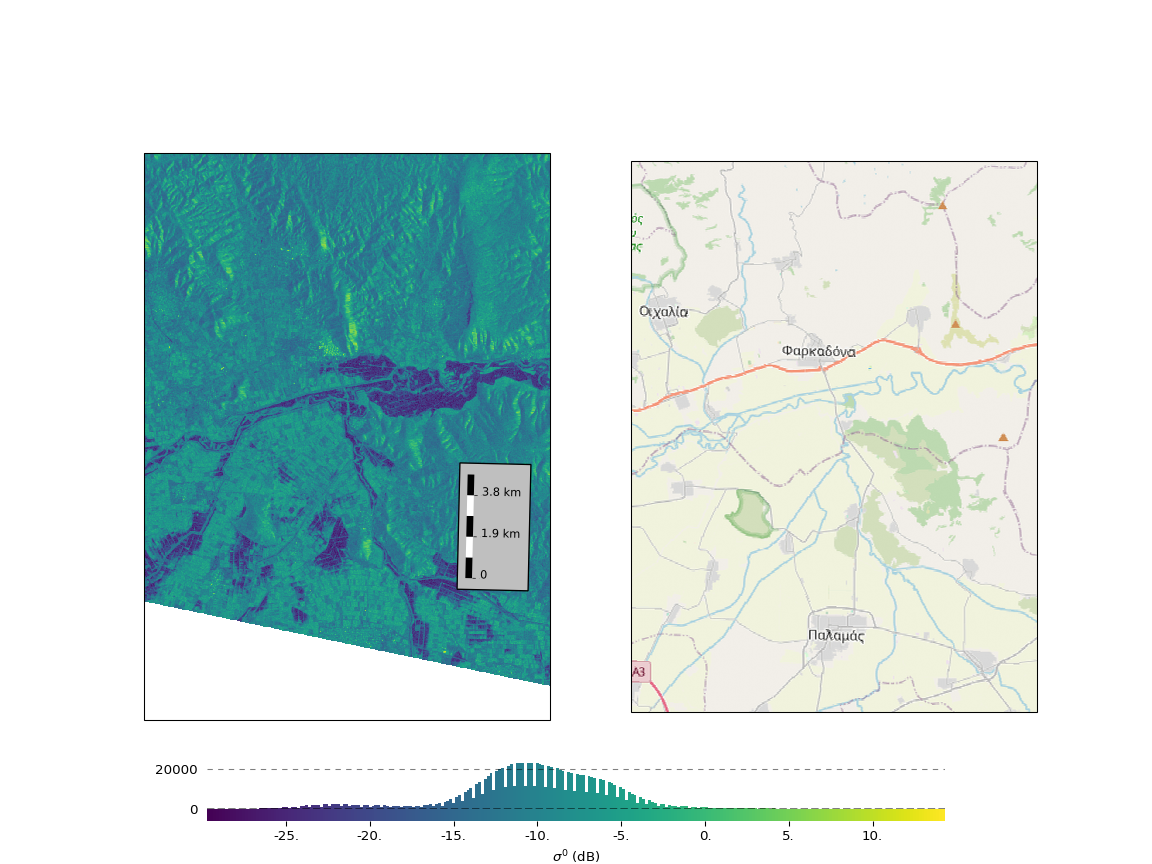

In [2]:
#| label: fig-area
#| fig-cap: 'Zielgebiet der $\sigma^0$-Rückstreuung ist die griechische Region Thessalien, die im Februar 2018 von einer großen Überschwemmung betroffen war.'
m = Maps(ax=121, figsize=(12, 9), crs=Maps.CRS.Equi7_EU)
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=Maps.CRS.Equi7_EU)
m.plot_map()
m.add_colorbar(label="$\sigma^0$ (dB)", pos=(0.1, 0.02, 0.8, 0.1))
m.add_scalebar(n=5)
m2 = m.new_map(ax=122, crs=Maps.CRS.Equi7_EU)
m2.set_extent(m.get_extent())
m2.add_wms.OpenStreetMap.add_layer.default()
m.show()

---

## Mikrowellenrückstreuung über Land und Wasser

Reverend Bayes befasste sich mit zwei Ereignissen, von denen eines, die „Hypothese“, vor dem anderen, dem „Beweis“, eintrat. Wenn wir die Ursache kennen, ist es einfach, logisch auf die Wahrscheinlichkeit einer Wirkung zu schließen. In diesem Fall wollen wir jedoch die Wahrscheinlichkeit einer Ursache aus einer beobachteten Wirkung ableiten, auch bekannt als „umgekehrte Wahrscheinlichkeit“. Im Fall der Hochwasserkartierung haben wir $\sigma^0$ Rückstreuungsbeobachtungen über Land (Wirkung), und wir wollen die Wahrscheinlichkeit von Überflutung (F) und Nicht-Überflutung (NF) ableiten. 

Anders ausgedrückt: Wir wollen die Überflutungswahrscheinlichkeit eines Pixels bei einem $\sigma^0$ kennen:

$$P(F|\sigma^0)$$

und die Wahrscheinlichkeit, dass ein Pixel bei einem bestimmten $\sigma^0$ nicht überflutet wird:

$$P(NF|\sigma^0).$$

Bayes zeigte, dass diese aus der Beobachtung abgeleitet werden können, dass die Vorwärts- und Rückwärtswahrscheinlichkeit gleich sind, so dass:

$$P(F|\sigma^0)P(\sigma^0) = P(\sigma^0|F)P(F)$$

and

$$P(NF|\sigma^0)P(\sigma^0) = P(\sigma^0|NF)P(NF).$$

Die Vorwärtswahrscheinlichkeit von $\sigma^0$ bei Überschwemmung ($P(\sigma^0|F)$) und $\sigma^0$ bei Nichtüberschwemmung ($P(\sigma^0|NF)$) lässt sich aus vergangenen Informationen über die Rückstreuung über Land- und Wasserflächen ableiten. Wie in der nachstehenden Skizze (Abbildung 2) zu sehen ist, unterscheiden sich die Eigenschaften der Rückstreuung über Land und Wasser erheblich.

![Schematische Rückstreuung über Land und Wasser. Bild von [Geological Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg){#fig-sat}


## Eintrittswahrscheinlichkeiten

Diese so genannten Wahrscheinlichkeiten $P(\sigma^0|F)$ und $P(\sigma^0|NF)$ lassen sich also aus den Rückstreuungsinformationen der Vergangenheit berechnen. Ohne auf die Einzelheiten der Berechnung dieser Wahrscheinlichkeiten einzugehen, kann man durch einem **Klick** auf ein Pixel der Karte die Wahrscheinlichkeiten dafür darstellen, dass $\sigma^0$ von Land oder Wasser bestimmt wird.


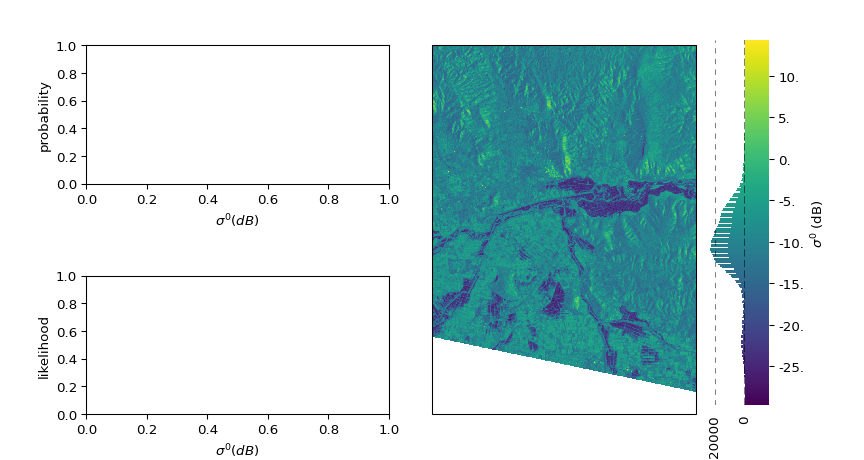

In [3]:
#| fig-cap: Wahrscheinlichkeiten dafür, dass $\\sigma^0$ mit Land oder Wasser assoziiert ist, für 1 Pixel im griechischen Gebiet von Thessalien. Die Wahrscheinlichkeiten werden über einen Bereich von $\\sigma^0$ berechnet. Der beobachtete $\\sigma^0$ des Pixels ist durch eine vertikale Linie dargestellt. Klicken Sie auf die Karte, um diese Abbildung für ein anderes Pixel im Untersuchungsgebiet neu zu berechnen und zu aktualisieren. Die Karte wurde mit EOmaps [@quast_getting_2024] erstellt.
view_bayes_flood(sig0_dc)

## Posteriors

Nachdem wir die Wahrscheinlichkeiten berechnet haben, können wir nun die Wahrscheinlichkeit des (Nicht-)Überflutens eines Pixels mit dem $\sigma^0$ berechnen. Diese sogenannten „Posterioren“ benötigen eine weitere Information, wie in der obigen Gleichung zu sehen ist. Wir benötigen die Wahrscheinlichkeit, ob ein Pixel überflutet $P(F)$ oder nicht überflutet $P(NF)$ ist. Wir können diese Information natürlich nicht genau abschätzen, also ist unsere beste Schätzung, dass die Wahrscheinlichkeit, dass ein Pixel überflutet oder nicht überflutet ist, 50:50 ist: ein Münzwurf. Diese subjektive Vorannahme ist eine Grundlage der Bayes'schen Statistik, und wir verwenden die Wahrscheinlichkeit, um unseren Glauben an diese spezielle Hypothese zu aktualisieren. Wir können nun auch die Rückstreuungswahrscheinlichkeit $P(\sigma^0)$ als gewichtetes Mittel der Wahrscheinlichkeiten für Wasser und Land berechnen. Letzteres stellt sicher, dass unsere aktualisierte Evidenz (oder Posterioren) zwischen 0 und 1 liegt.

Der folgende Codeblock zeigt, wie wir die Prioritäten berechnen.


In [4]:
def calc_posteriors(water_likelihood, land_likelihood):
    evidence = (water_likelihood * 0.5) + (land_likelihood * 0.5)
    return (water_likelihood * 0.5) / evidence,  (land_likelihood * 0.5) / evidence

Wir können diese posterioren Wahrscheinlichkeiten für Überflutung und Nicht-Überflutung wieder aufzeichnen und mit dem gemessenen $\sigma^0$ des Pixels vergleichen. **Klicken** Sie auf ein Pixel, um die posteriore Wahrscheinlichkeit zu berechnen.


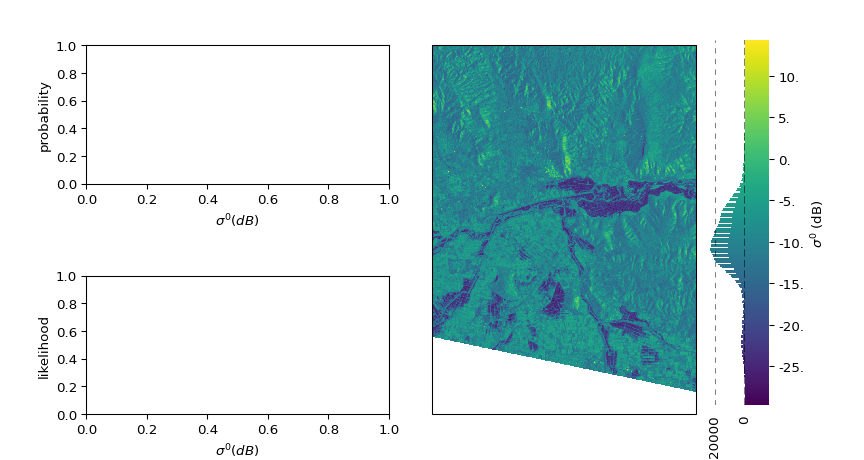

In [5]:
#| label: fig-post
#| fig-cap: 'Posteriorwahrscheinlichkeiten für $\sigma^0$, dass 1 Pixel mit Land für Wasser im griechischen Gebiet Thessalien assoziiert ist. Klicken Sie auf die Karte, um diese Abbildung für ein anderes Pixel im Untersuchungsgebiet neu zu berechnen und zu aktualisieren. Die Karte wurde mit EOmaps [@quast_getting_2024] erstellt.'
view_bayes_flood(sig0_dc, calc_posteriors)

## Hochwasser-Klassifizierung

Jetzt können wir all diese Informationen kombinieren und die Pixel nach der Wahrscheinlichkeit einer Überschwemmung klassifizieren, wenn der Backscaterr-Wert von 1 Pixel gegeben ist. Hier schauen wir nur, ob die Wahrscheinlichkeit einer Überflutung höher ist als die einer Nicht-Überflutung:


In [6]:
def bayesian_flood_decision(id, sig0_dc):
    nf_post_prob, f_post_prob = calc_posteriors(*calc_likelihoods(id,  sig0_dc))
    return np.greater(f_post_prob, nf_post_prob)

**Klicken** Sie auf einen Punkt in der untenstehenden Karte, um die Likelihoods und Posterior-Verteilungen (in den linken Subplots) zu sehen.


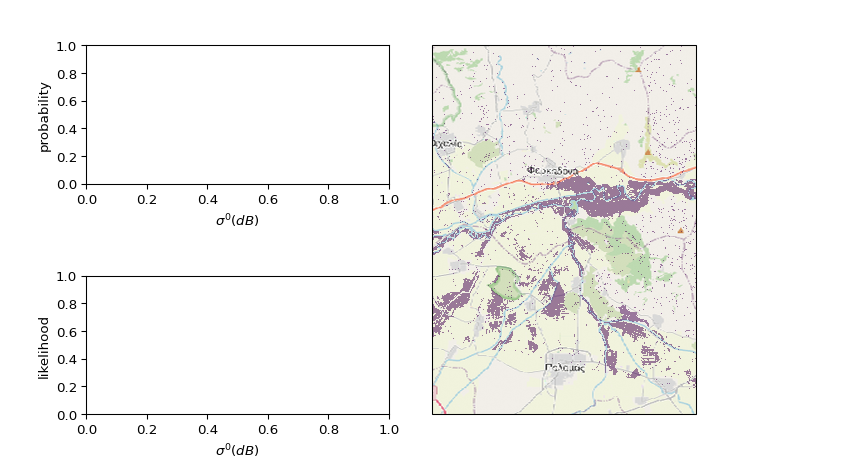

In [7]:
#| label: fig-clas
#| fig-cap: 'Die Ausdehnung der Überschwemmungen in der griechischen Region Thessalien auf der Grundlage von Bayes''schen Wahrscheinlichkeiten wird auf der Karte über einer offenen Straßenkarte angezeigt. Klicken Sie auf ein Pixel, um die Wasser- und Landwahrscheinlichkeiten des Punktes sowie die posterioren Wahrscheinlichkeiten zu generieren. Die Karte wurde mit EOmaps [@quast_getting_2024] erstellt.'
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)